# **Imports e Extração de Arquivos**

In [ ]:
!pip install scikit-image
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install pandas
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 84.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
from skimage import util, transform, filters, color, measure, morphology
from skimage.measure import label, regionprops_table
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection, neighbors, metrics, preprocessing
from scipy import spatial, stats
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import zipfile
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


Extrair o dataset

In [7]:
#usado para descompactar arquivos zip
path = "mpeg7_mod.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("/workspaces/classificandoimagens")
zip_object.close()


# **Funções**

Carregar e Redimensionar Dataset

In [8]:
def carregar_dados (path, resize_factor = 0.25):
  classes_list = os.listdir(path) #lista das classes do dataset
  print(classes_list)

  image_list, label_list, filename_list, label_list_idx = [], [], [], []
  for classe in classes_list:
    file_paths = os.listdir(os.path.join(path, classe)) #todas as imagens em cada pasta

    for filename in file_paths: #todos os arquivos na pasta atual
      img_temp = plt.imread(os.path.join(path, classe, filename)) #carrega a imagem
      img_temp = transform.resize(img_temp, (int(img_temp.shape[0]*resize_factor), int(img_temp.shape[1]*resize_factor)), anti_aliasing=True)
    #redimensiona a imagem para 1/4 do tamanho original
      image_list.append(img_temp)
      label_list.append(classe)
      filename_list.append(filename)
      #print(label_list) #lista de labels

  #-----Convertendo os nomes das classes para índices numéricos-----
  # Indices das classes dos objetos do dataset
  _, _, label_list_idx = np.unique(label_list, return_index=True, return_inverse=True)

  #print(type(label_list_idx))
  #print(label_list_idx)

  return image_list, label_list, filename_list, label_list_idx

Normalizar as Imagens

In [9]:
def normalizar_imagens(image_list):
    norm_images = []
    for image in image_list:
        image = image / 255.0 if image.max() > 1 else image
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        norm_images.append(image)
    return norm_images

Segmentar as Imagens

In [10]:
def segmentar_imagens(image):
  if image.ndim > 2:
    image = color.rgb2gray(image)
  img_seg = image > filters.threshold_otsu(image)
  props = regionprops_table(label(img_seg), properties=['area', 'major_axis_length', 'solidity', 'eccentricity'])

  props = pd.DataFrame(props)
  if len(props) == 1:
    return pd.Series(props.loc[0]), img_seg
  return None, img_seg

Extrair as Características

In [11]:
import pandas as pd #Import pandas for working with Series

def extrair_caracteristicas(image_list):
  features = []
  segmented_images = []
  for image in image_list:
    prop, img_seg = segmentar_imagens(image)
    if isinstance(prop, pd.Series) and not prop.empty:
      if prop['area'] > 0:
        features.append([prop.area, prop.major_axis_length, prop.solidity, prop.eccentricity])
        segmented_images.append(img_seg)
    elif prop:
      features.append([prop.area, prop.major_axis_length, prop.solidity, prop.eccentricity])
      segmented_images.append(img_seg)
      return np.array(features), segmented_images

  return np.array(features), segmented_images


Divisão do Dataset

In [12]:
def divisao (feature_map, label_list, test_size = 0.3, val_size = 0.2):

  X_train, X_temp, y_train, y_temp = train_test_split(feature_map,
                                                      label_list,
                                                      test_size=test_size,
                                                      random_state=42)
  test_size_adjust = 1-(val_size / (1 - test_size))
  X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                  y_temp,
                                                  test_size=test_size_adjust,
                                                  random_state=42)

  scaler = StandardScaler().fit(X_train)
  X_train_norm = scaler.transform(X_train)
  X_test_norm = scaler.transform(X_test)
  X_val_norm = scaler.transform(X_val)


  return X_train_norm, X_val_norm, X_test_norm, y_train, y_val, y_test

Treinar e Avaliar um Modelo

In [13]:
def treinar_e_avaliar(model, X_train, X_val, X_test, y_train, y_val, y_test):
  model.fit(X_train, y_train)

  #avaliar no conjunto de validação
  y_val_pred = model.predict(X_val)
  val_accuracy = accuracy_score(y_val, y_val_pred)
  print(f"Acurácia no conjunto de validação: {val_accuracy: .4f}")
  print('Matriz de Confusão (Validação):')
  print(metrics.confusion_matrix(y_val, y_val_pred))
  print('\nRelatório de Classificação (Validação):')
  print(metrics.classification_report(y_val, y_val_pred))

  #avaliar no conjunto de teste
  y_test_pred = model.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print(f"Acurácia no conjunto de teste: {test_accuracy: .4f}")
  print('Matriz de Confusão (Teste):')
  print(metrics.confusion_matrix(y_test, y_test_pred))
  print('\nRelatório de Classificação (Teste):')
  print(metrics.classification_report(y_test, y_test_pred))

Plotando as imagens do conjunto de dados

In [14]:
def plotar_imagens(image_list, label_list_idx, filename_list):
  # Seleciona apenas as primeiras N imagens de cada classe
  image_list_temp = []
  filename_list_temp = []

  if image_list[0].dtype != np.uint8:
        # Converte imagens para o formato uint8
        image_list = [(img * 255).astype(np.uint8) for img in image_list]

  # Itera pelo número de classes
  for i in range(3):
      # As 6 primeiras ocorrências em que label é igual a 'i'.
      image_list_temp += [image_list[j] for j in np.where(label_list_idx == i)[0][:6]]
      filename_list_temp += [filename_list[j] for j in np.where(label_list_idx == i)[0][:6]]

  fig, ax = plt.subplots(3, 6, figsize=(9, 5))

  for i, (image, filename) in enumerate(zip(image_list_temp, filename_list_temp)):
      # Verificação de formato e normalização
      if image.max() > 1:
          image = image / 255.0  # Normaliza valores para 0-1, se necessário

      if len(image.shape) == 2:  # Imagem em escala de cinza (1 canal)
          image = np.stack([image] * 3, axis=-1)  # Converte para 3 canais (RGB)

      ax[i // 6, i % 6].imshow(image, vmin=0, vmax=1)  # Ajuste de vmin e vmax para 0-1
      ax[i // 6, i % 6].set_title(str(filename))
      ax[i // 6, i % 6].axis('off')

  fig.tight_layout()
  plt.show()



Plotando as caracteristicas computadas


In [15]:
def plotar_caracteristicas(feature_map, label_list_idx):
  #passar o feature_map e o feature map normalizado
  features = ['area', 'major_axis', 'solidity', 'eccentricity']
  df = pd.DataFrame(feature_map, columns=features)

  label_list_idx = label_list_idx[:len(df)]
  if label_list_idx is not None:
    df['class'] = label_list_idx

  g = sns.PairGrid(df, hue='class', vars=features)
  g.fig.set_size_inches(8, 8)
  g.map_diag(sns.histplot)
  g.map_offdiag(sns.scatterplot)
  g.add_legend()

# Execução

Caminho do dataset

In [16]:
ds_path = "/workspaces/classificandoimagens/mpeg7_mod"

Carregamento de Dados

['apple', 'bird', 'bone', 'bell', 'beetle', 'bat']


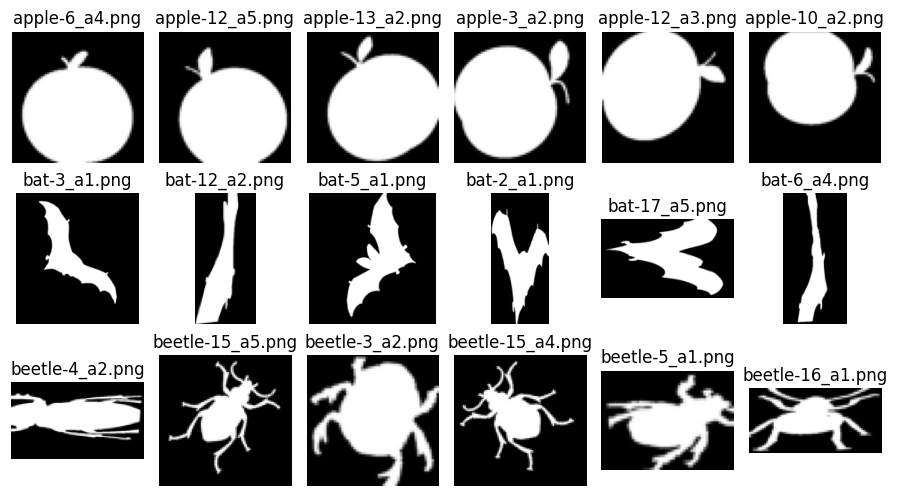

In [17]:
image_list, label_list, filename_list, label_list_idx = carregar_dados(ds_path)
image_list = normalizar_imagens(image_list)
plotar_imagens(image_list, label_list_idx, filename_list)

Extração de Características

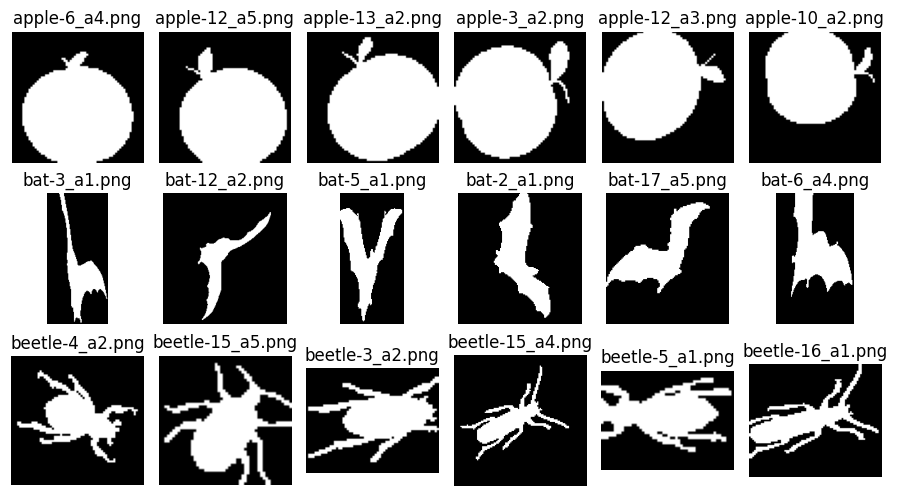

In [18]:
feature_map, seg_images = extrair_caracteristicas(image_list)
plotar_imagens(seg_images, label_list_idx, filename_list)


Características Computadas

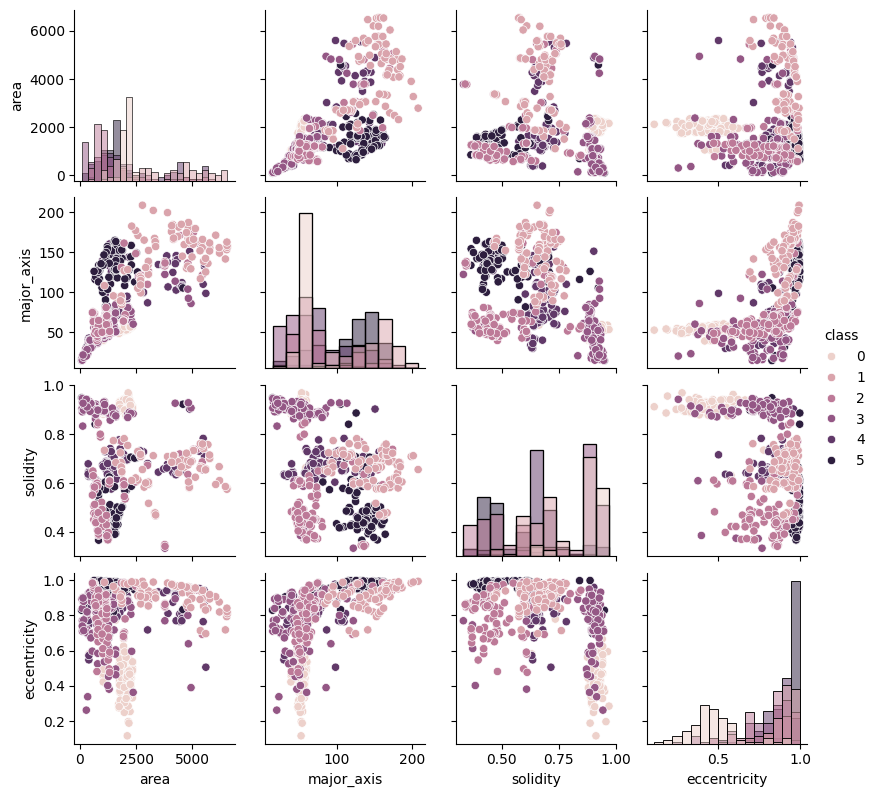

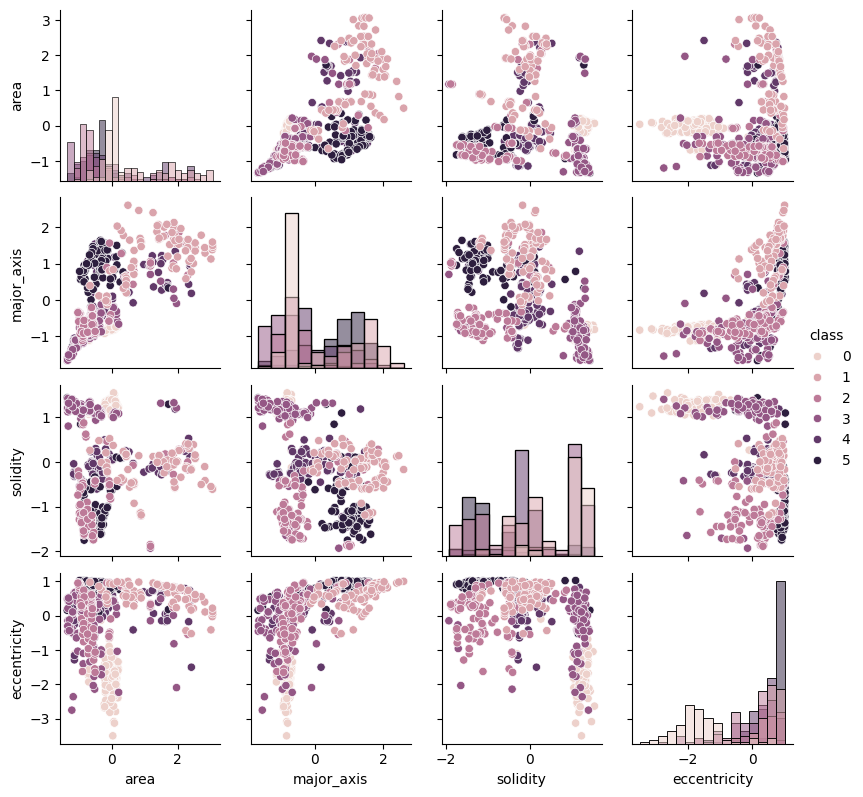

In [19]:
plotar_caracteristicas(feature_map, label_list_idx)

# Transformada Normal de Caracteristicas
feature_map_norm = (feature_map - feature_map.mean(0)) / feature_map.std(0)

plotar_caracteristicas(feature_map_norm, label_list_idx)

Divisão de Dados e Normalização

In [20]:
X_train, X_val, X_test, y_train, y_val, y_test = divisao(feature_map, label_list[:len(feature_map)])

Treinamento e Avaliação

In [21]:
model1 = neighbors.KNeighborsClassifier(n_neighbors=1)
print("----------KNN (K=1)-------------")
treinar_e_avaliar(model1, X_train, X_val, X_test, y_train, y_val, y_test)

print("----------SVC (RBF)-------------")
model2 = SVC(kernel='rbf')
treinar_e_avaliar(model2, X_train, X_val, X_test, y_train, y_val, y_test)

----------KNN (K=1)-------------
Acurácia no conjunto de validação:  0.8320
Matriz de Confusão (Validação):
[[23  0  0  0  2  0]
 [ 0 18  1  0  1  0]
 [ 0  2 19  0  2  1]
 [ 1  0  2 13  0  2]
 [ 2  0  0  0 14  2]
 [ 0  1  1  1  0 17]]

Relatório de Classificação (Validação):
              precision    recall  f1-score   support

       apple       0.88      0.92      0.90        25
         bat       0.86      0.90      0.88        20
      beetle       0.83      0.79      0.81        24
        bell       0.93      0.72      0.81        18
        bird       0.74      0.78      0.76        18
        bone       0.77      0.85      0.81        20

    accuracy                           0.83       125
   macro avg       0.83      0.83      0.83       125
weighted avg       0.84      0.83      0.83       125

Acurácia no conjunto de teste:  0.8627
Matriz de Confusão (Teste):
[[12  0  0  0  0  0]
 [ 0  5  0  0  0  0]
 [ 0  1  5  0  0  0]
 [ 1  0  0  4  0  1]
 [ 0  1  0  0 11  0]
 [ 0  1  